<a href="https://colab.research.google.com/github/HashirNauman/Healthcare-Disease-Prediction/blob/main/Health_Care_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#requirements
!pip install pandas numpy scikit-learn joblib

Best hyperparameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Grid Search Results:
     max_depth  min_samples_split  n_estimators  mean_test_score
7        10.0                  5           200         0.809840
1         NaN                  2           200         0.801418
9        20.0                  2           200         0.801418
3         NaN                  5           200         0.801330
11       20.0                  5           200         0.801330
Test Accuracy: 0.8833
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90        36
           1       0.84      0.88      0.86        24

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



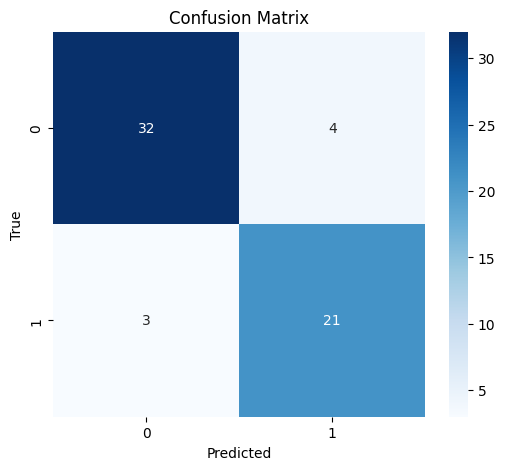

Model saved to models/heart_disease_model.pkl


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Constants
DATA_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
COLUMN_NAMES = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
    "exang", "oldpeak", "slope", "ca", "thal", "target"
]
CATEGORICAL_COLS = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
NUMERICAL_COLS = ["age", "trestbps", "chol", "thalach", "oldpeak"]


def load_data():
    """Load the Heart Disease UCI dataset from the URL."""
    df = pd.read_csv(DATA_URL, names=COLUMN_NAMES, na_values="?")
    df.dropna(inplace=True)
    return df


def preprocess_data(df):
    """Encode categorical variables and scale numerical features; binarize target."""
    le = LabelEncoder()
    for col in CATEGORICAL_COLS:
        df[col] = le.fit_transform(df[col].astype(str))

    scaler = StandardScaler()
    df[NUMERICAL_COLS] = scaler.fit_transform(df[NUMERICAL_COLS])

    df["target"] = df["target"].apply(lambda x: 1 if x > 0 else 0)
    return df


def build_model():
    """Return a RandomForestClassifier instance."""
    return RandomForestClassifier(random_state=42)


def tune_hyperparameters(model, X_train, y_train):
    """Use GridSearchCV to find the best RF hyperparameters."""
    param_grid = {
        "n_estimators": [100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5]
    }
    grid = GridSearchCV(model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)
    print("Best hyperparameters:", grid.best_params_)
    return grid.best_estimator_, grid.cv_results_


def main():
    df = load_data()
    df = preprocess_data(df)

    X = df.drop("target", axis=1)
    y = df["target"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = build_model()
    best_model, cv_results = tune_hyperparameters(model, X_train, y_train)

    # Cross-validation performance summary
    mean_scores = cv_results['mean_test_score']
    params = cv_results['params']
    summary = pd.DataFrame(params)
    summary['mean_test_score'] = mean_scores
    print("Grid Search Results:\n", summary.sort_values('mean_test_score', ascending=False).head())

    # Train best model
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    # Evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {acc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Save model
    os.makedirs('models', exist_ok=True)
    joblib.dump(best_model, os.path.join('models', 'heart_disease_model.pkl'))
    print("Model saved to models/heart_disease_model.pkl")

if __name__ == '__main__':
    main()
